In [10]:
import math
import numpy as np
import matplotlib.pyplot as plt
import intvalpy as ip

In [11]:
def is_tolerance_set_empty(A, b):
    max_tol = ip.linear.Tol.maximize(A, b)
    return max_tol[1] < 0, max_tol[0]


def b_correction(b, k):
    e = ip.Interval([[-k, k] for i in range(len(b))])
    return b + e

In [12]:
def find_b_correction_min_K(A, b, eps=10e-3, max_iterations=500):
    prev_k = 0
    cur_k = 0
    iteration = 0
    corrected_b = b
    is_empty, _ = is_tolerance_set_empty(A, corrected_b)
    while is_empty and iteration <= max_iterations:
        prev_k = cur_k
        cur_k = math.exp(iteration)
        corrected_b = b_correction(b, cur_k)
        is_empty, _ = is_tolerance_set_empty(A, corrected_b)
        iteration += 1
    if is_empty:
        raise Exception('Could not find K for b-correction')
    iteration = 0
    while abs(prev_k - cur_k) > eps and iteration <= max_iterations:
        mid_k = (prev_k + cur_k) / 2
        corrected_b = b_correction(b, mid_k)
        is_empty, _ = is_tolerance_set_empty(A, corrected_b)
        if is_empty:
            prev_k = mid_k
        else:
            cur_k = mid_k
        iteration += 1
    corrected_b = b_correction(b, cur_k)
    return corrected_b, cur_k, iteration

In [13]:
def A_correction(A, b):
    max_tol = ip.linear.Tol.maximize(A, b)
    lower_bound = abs(max_tol[1]) / (abs(max_tol[0][0]) + abs(max_tol[0][1]))

    rad_A = ip.rad(A)
    upper_bound = rad_A[0][0]

    for a_i in rad_A:
        for a_ij in a_i:
            if a_ij < upper_bound:
                upper_bound = a_ij
    e = (lower_bound + upper_bound) / 2
    corrected_A = []

    for i in range(len(A)):
        A_i = []

        for j in range(len(A[0])):
            A_i.append([A[i][j]._a + e, A[i][j]._b - e])

        corrected_A.append(A_i)

    return ip.Interval(corrected_A)

In [19]:
def plot_tol(axis, A, b):
    max_tol = ip.linear.Tol.maximize(A, b)
    print(A, b, max_tol)

    grid_min, grid_max = max_tol[0][0] - 2, max_tol[0][0] + 2
    x_1_, x_2_ = np.mgrid[grid_min:grid_max:70j, grid_min:grid_max:70j]
    list_x_1 = np.linspace(grid_min, grid_max, 70)
    list_x_2 = np.linspace(grid_min, grid_max, 70)

    list_tol = np.zeros((70, 70))

    for idx_x1, x1 in enumerate(list_x_1):
        for idx_x2, x2 in enumerate(list_x_2):
            x = [x1, x2]
            tol_values = []

            for i in range(len(b)):
                sum_ = sum(A[i][j] * x[j] for j in range(len(x)))
                rad_b, mid_b = ip.rad(b[i]), ip.mid(b[i])
                tol = rad_b - ip.mag(mid_b - sum_)
                tol_values.append(tol)

            list_tol[idx_x1, idx_x2] = min(tol_values)

    axis.view_init(elev=30, azim=225)
    axis.plot_surface(x_1_, x_2_, list_tol, cmap='magma')
    axis.scatter(*max_tol[0], max_tol[1], color='blue', s=50)

In [20]:
def plot_tol_functional(axis, A, b):
    max_tol = ip.linear.Tol.maximize(A, b)
    solution = max_tol[0]

    x = np.linspace(float(solution[0]) - 2, float(solution[0]) + 2, 101)
    y = np.linspace(float(solution[1]) - 2, float(solution[1]) + 2, 101)
    xx, yy = np.meshgrid(x, y)
    zz = np.array(
        [[1 if ip.linear.Tol.value(A, b, [x, y]) >= 0 else 0 for x, y in zip(x_row, y_row)] for x_row, y_row in
         zip(xx, yy)])

    axis.contourf(xx, yy, zz, levels=1, colors=['red', 'green'])
    axis.scatter(solution[0], solution[1], color='red', marker='x', s=50)
    axis.set_xlabel('x_1')
    axis.set_ylabel('x_2')

Interval([['[0.65, 1.25]', '[0.7, 1.3]'],
       ['[0.75, 1.35]', '[0.7, 1.3]']]) Interval(['[2.75, 3.15]', '[2.85, 3.25]']) (array([1., 2.]), mpf('-0.700000000000000704991620636974403168818'), 29, 50, 1)
Interval([['[0.65, 1.25]', '[0.7, 1.3]'],
       ['[0.75, 1.35]', '[0.7, 1.3]']]) Interval(['[1.75, 4.15]', '[1.85, 4.25]']) (array([1., 2.]), mpf('0.299999999999999295008379363025596831182'), 29, 50, 1)
Interval([['[0.916667, 0.983333]', '[0.966667, 1.03333]'],
       ['[1.01667, 1.08333]', '[0.966667, 1.03333]']]) Interval(['[2.75, 3.15]', '[2.85, 3.25]']) (array([1., 2.]), mpf('0.0999999999999996178982423581752776273432'), 29, 43, 1)
Interval([['[0.916667, 0.983333]', '[0.966667, 1.03333]'],
       ['[1.01667, 1.08333]', '[0.966667, 1.03333]']]) Interval(['[1.75, 4.15]', '[1.85, 4.25]']) (array([1., 2.]), mpf('1.09999999999999961789824235817527762734'), 29, 43, 1)
Interval([['[0.65, 1.25]', '[0.7, 1.3]'],
       ['[0.75, 1.35]', '[0.7, 1.3]'],
       ['[0.8, 1.4]', '[0.7, 1.3]']]) 

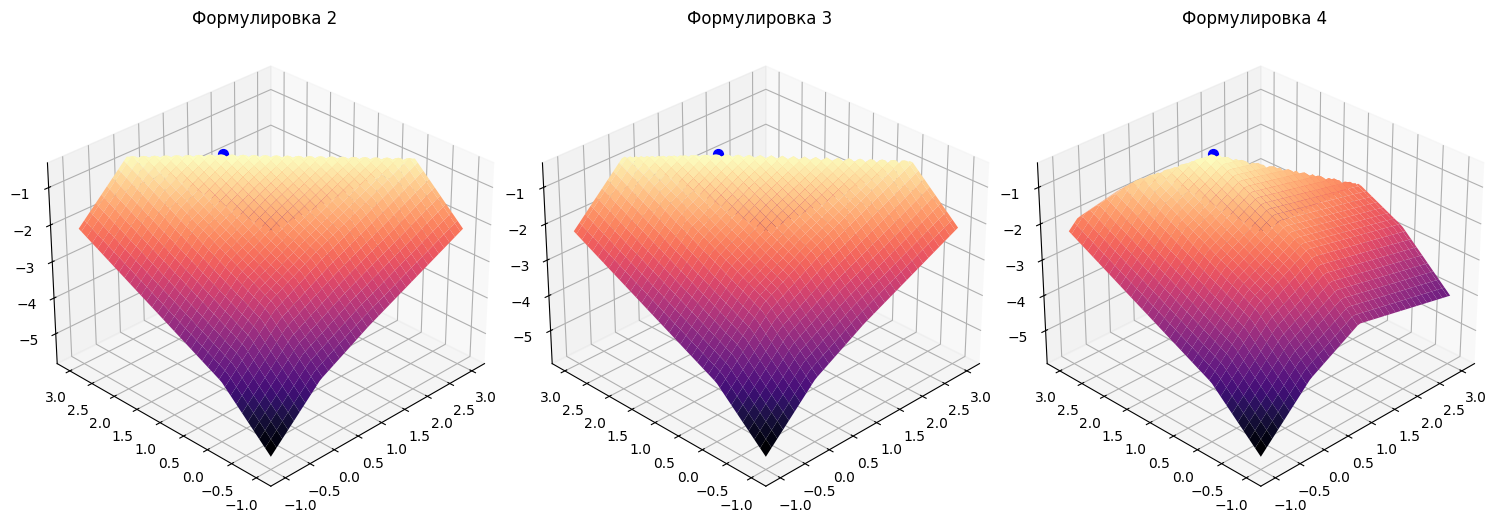

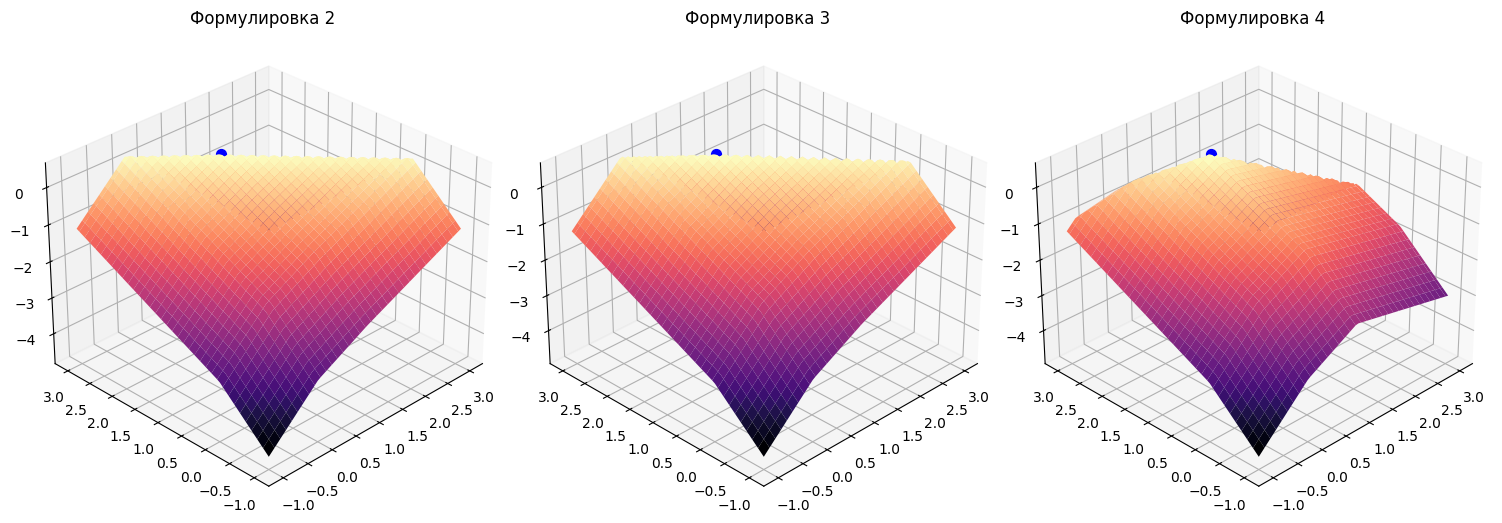

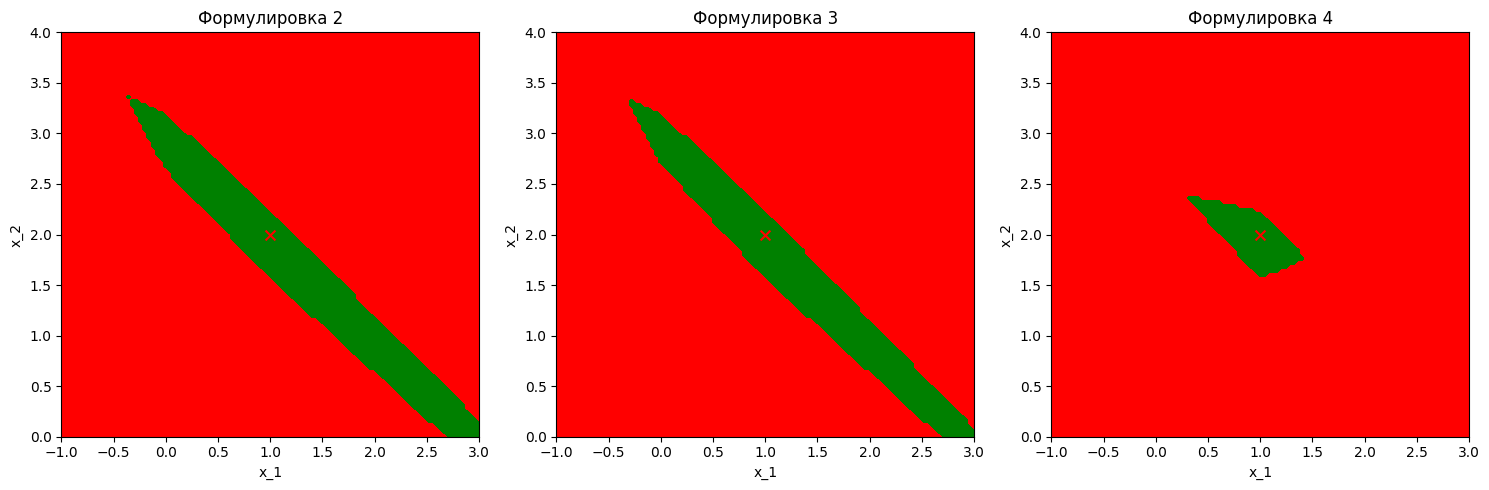

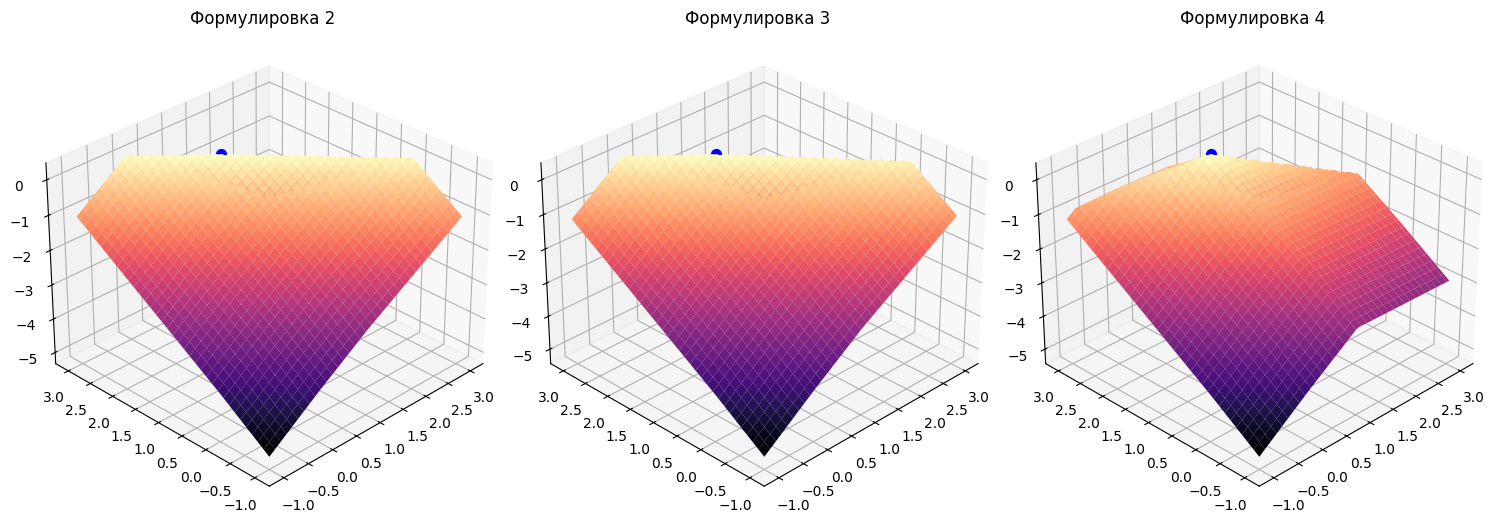

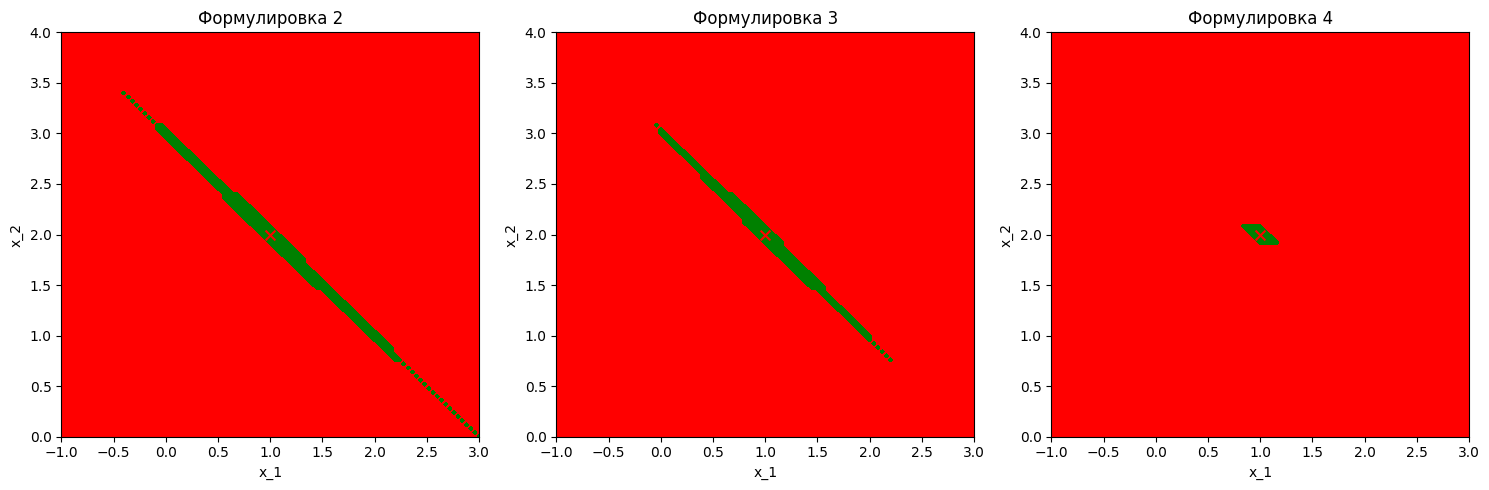

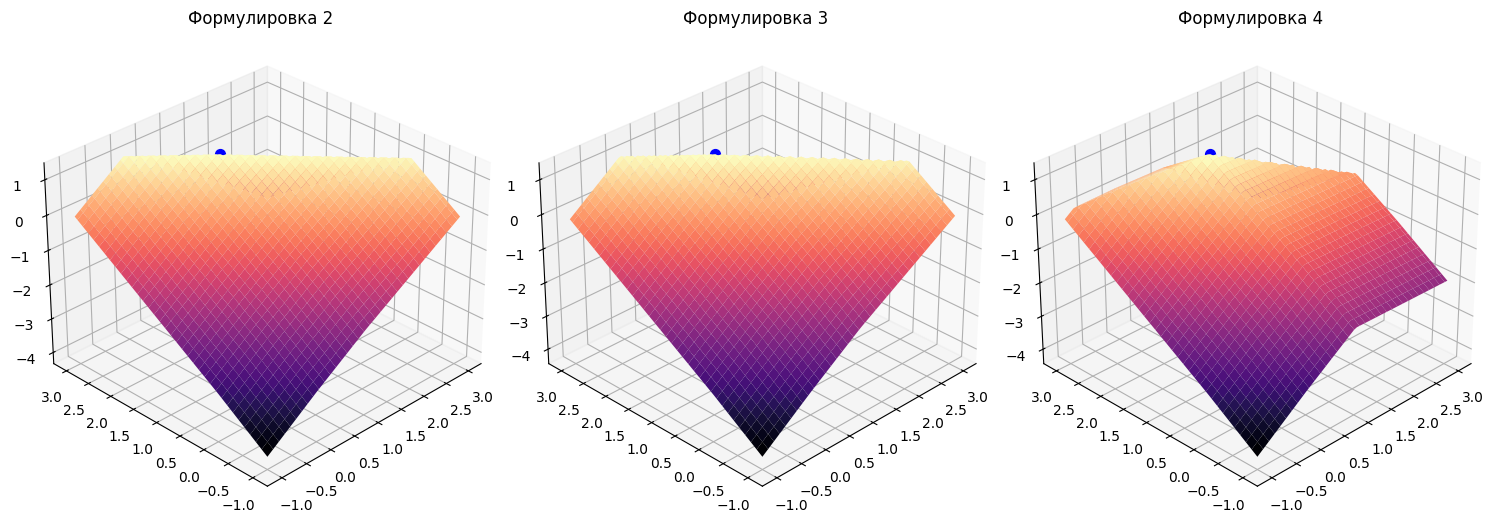

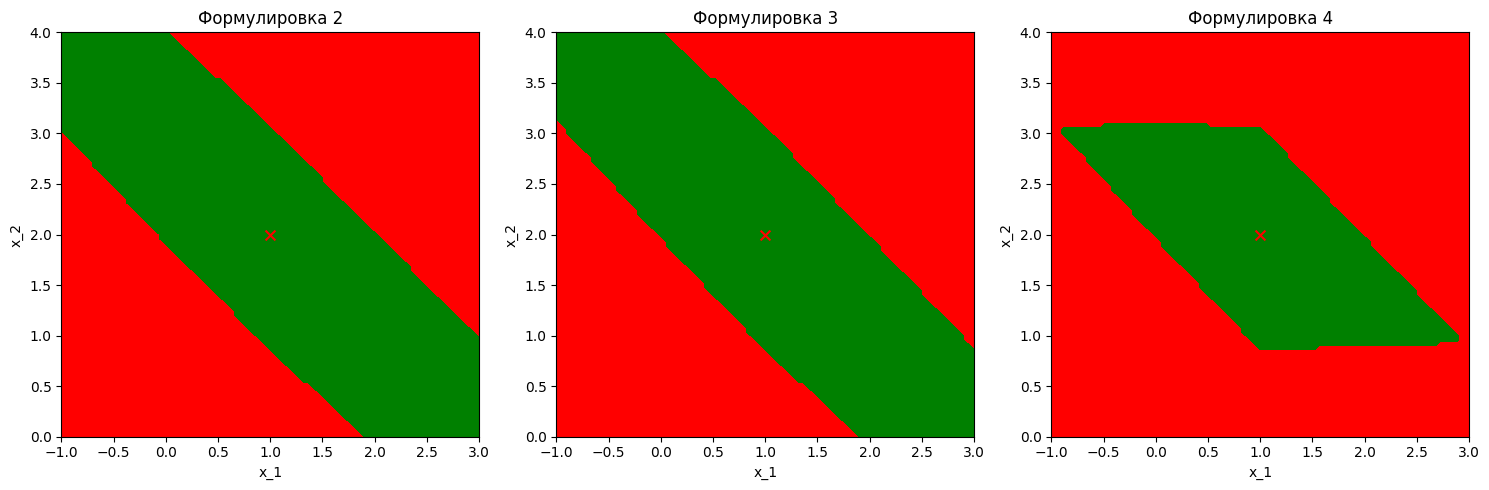

In [21]:
A_1 = ip.Interval([
    [[0.65, 1.25], [0.70, 1.3]],
    [[0.75, 1.35], [0.70, 1.3]]
])
b_1 = ip.Interval([
    [2.75, 3.15],
    [2.85, 3.25],
])

A_2 = ip.Interval([
    [[0.65, 1.25], [0.70, 1.3]],
    [[0.75, 1.35], [0.70, 1.3]],
    [[0.8, 1.4], [0.70, 1.3]],
])
b_2 = ip.Interval([
    [2.75, 3.15],
    [2.85, 3.25],
    [2.90, 3.3],
])

A_3 = ip.Interval([
    [[0.65, 1.25], [0.70, 1.3]],
    [[0.75, 1.35], [0.70, 1.3]],
    [[0.8, 1.4], [0.70, 1.3]],
    [[-0.3, 0.3], [0.70, 1.3]],
])
b_3 = ip.Interval([
    [2.75, 3.15],
    [2.85, 3.25],
    [2.90, 3.3],
    [1.8, 2.2],
])

systems = (
    (A_1, b_1),
    (A_2, b_2),
    (A_3, b_3),
)
fig_raw = plt.figure(figsize=(15, 6))

fig_b_corrected = plt.figure(figsize=(15, 6))
fig_b_corrected_2d = plt.figure(figsize=(15, 5))

fig_a_corrected = plt.figure(figsize=(15, 6))
fig_a_corrected_2d = plt.figure(figsize=(15, 5))

fig_ab_corrected = plt.figure(figsize=(15, 6))
fig_ab_corrected_2d = plt.figure(figsize=(15, 5))

for index, (A, b) in enumerate(systems):
    axis_raw = fig_raw.add_subplot(131 + index, projection='3d')
    axis_raw.set_title(f'Формулировка {index + 2}')
    plot_tol(axis_raw, A, b)

    b_corrected = b_correction(b, 1)

    axis_b_corrected = fig_b_corrected.add_subplot(131 + index, projection='3d')
    axis_b_corrected.set_title(f'Формулировка {index + 2}')
    plot_tol(axis_b_corrected, A, b_corrected)

    axis_b_corrected_2d = fig_b_corrected_2d.add_subplot(131 + index)
    axis_b_corrected_2d.set_title(f'Формулировка {index + 2}')
    plot_tol_functional(axis_b_corrected_2d, A, b_corrected)

    A_corrected = A_correction(A, b)

    axis_a_corrected = fig_a_corrected.add_subplot(131 + index, projection='3d')
    axis_a_corrected.set_title(f'Формулировка {index + 2}')
    plot_tol(axis_a_corrected, A_corrected, b)

    axis_a_corrected_2d = fig_a_corrected_2d.add_subplot(131 + index)
    axis_a_corrected_2d.set_title(f'Формулировка {index + 2}')
    plot_tol_functional(axis_a_corrected_2d, A_corrected, b)

    axis_ab_corrected = fig_ab_corrected.add_subplot(131 + index, projection='3d')
    axis_ab_corrected.set_title(f'Формулировка {index + 2}')
    plot_tol(axis_ab_corrected, A_corrected, b_corrected)

    axis_ab_corrected_2d = fig_ab_corrected_2d.add_subplot(131 + index)
    axis_ab_corrected_2d.set_title(f'Формулировка {index + 2}')
    plot_tol_functional(axis_ab_corrected_2d, A_corrected, b_corrected)

fig_raw.tight_layout()
fig_b_corrected.tight_layout()
fig_b_corrected_2d.tight_layout()
fig_a_corrected.tight_layout()
fig_a_corrected_2d.tight_layout()
fig_ab_corrected.tight_layout()
fig_ab_corrected_2d.tight_layout()

plt.show()